# A comparison of text distance algorithms

[![Run nbconvert](https://github.com/micheledinelli/text-distances/actions/workflows/readme.yaml/badge.svg)](https://github.com/micheledinelli/text-distances/actions/workflows/readme.yaml)

In [110]:
import numpy as np
import pandas as pd

import re
from collections import Counter

from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from scipy.stats import wasserstein_distance
from scipy.stats import entropy

from gensim.models import Word2Vec

from sklearn.decomposition import PCA

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

plt.style.use("style.mplstyle")

colors = ["#003f5c", "#d45087", "#ffa600", "#665191", "#ff7c43", "#2f4b7c", "#f95d6a", "#a05195"]

cmap = ListedColormap(sns.color_palette(colors).as_hex())

In [111]:
%%capture

# Download the necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/micheledinelli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/micheledinelli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/micheledinelli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Text distance: outline

- [Length distance](#length-distance)
  - Euclidean distance
  - Cosine distance
  - Manhattan distance
  - Hamming distance
- [Distribution distance](#distribution-distance)
  - JS divergence
  - KL divergence
  - Wasserstein distance
- [Semantic distance](#semantic-distance)
  - Word mover's distance
  - Word mover's distance extension

In [112]:
s1 = "Obama speaks to the media in Illinois"
s2 = "The president greets the press in Chicago"
s3 = "Duck"
s4 = "Cool"
s5 = "Rest"

corpus = [s1, s2, s3, s4, s5]

vectorizer = CountVectorizer()
vectorizer.fit(corpus)

matrix = vectorizer.fit_transform(corpus)

table = matrix.todense()
df = pd.DataFrame(table, 
                  columns=vectorizer.get_feature_names_out(), 
                  index=[f"s{i+1}" for i in range(len(corpus))])

df.head()

,chicago,cool,duck,greets,illinois,in,media,obama,president,press,rest,speaks,the,to
s1,0,0,0,0,1,1,1,1,0,0,0,1,1,1
s2,1,0,0,1,0,1,0,0,1,1,0,0,2,0
s3,0,0,1,0,0,0,0,0,0,0,0,0,0,0
s4,0,1,0,0,0,0,0,0,0,0,0,0,0,0
s5,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Length Distance <a id="length-distance"></a>

#### Algorithms

In [113]:
def euclidean_distance(s1, s2, vectorizer):
    vector1 = vectorizer.transform([s1]).toarray()
    vector2 = vectorizer.transform([s2]).toarray()
    distance = np.linalg.norm(vector1 - vector2)
    return distance

def cosine_distance(s1, s2, vectorizer):
    vector1 = vectorizer.transform([s1]).toarray()
    vector2 = vectorizer.transform([s2]).toarray()
    similarity_matrix = cosine_similarity(vector1, vector2)
    distance = 1 - similarity_matrix[0, 0]
    return distance

def manhattan_distance(s1, s2, vectorizer):
    vector1 = vectorizer.transform([s1]).toarray()
    vector2 = vectorizer.transform([s2]).toarray()
    distance = np.sum(np.abs(vector1 - vector2))
    return distance

def hamming_distance(s1, s2):
    if len(s1) != len(s2):
        raise ValueError("Both strings must be of the same length")
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))

In [114]:
print(f"Euclidean distance between {s3} and {s4}: {euclidean_distance(s3, s4, vectorizer):.2f}")
print(f"Cosine distance between {s3} and {s4}: {cosine_distance(s3, s4, vectorizer):.2f}")
print(f"Manhattan distance between {s3} and {s4}: {manhattan_distance(s3, s4, vectorizer):.2f}")
print(f"Hamming distance between {s3} and {s4}: {hamming_distance(s3, s4):.2f}")

Euclidean distance between Duck and Cool: 1.41
Cosine distance between Duck and Cool: 1.00
Manhattan distance between Duck and Cool: 2.00
Hamming distance between Duck and Cool: 4.00


In [115]:
def plot_distances(s1: str, s2: str, vectorizer, ax=None):
    if ax:
        # Calculate distances
        euclidean_dist = euclidean_distance(s1, s2, vectorizer)
        cosine_dist = cosine_distance(s1, s2, vectorizer)
        manhattan_dist = manhattan_distance(s1, s2, vectorizer)

        ax.scatter([s1, s2], [0, euclidean_dist], label='Euclidean', color=colors[0])
        ax.scatter([s1, s2], [0, cosine_dist], label='Cosine', color=colors[1])
        ax.scatter([s1, s2], [0, manhattan_dist], label='Manhattan', color=colors[2])

        # Connect the points with lines
        ax.plot([s1, s2], [0, euclidean_dist], linestyle='-', color=colors[0])
        ax.plot([s1, s2], [0, cosine_dist], linestyle='-', color=colors[1])
        ax.plot([s1, s2], [0, manhattan_dist], linestyle='-', color=colors[2])

        # Annotate the distance values
        ax.text(s1, 0, f'{s1}\n(0, 0)', ha='center', va='bottom')
        ax.text(s2, euclidean_dist, f'{s2}\n({euclidean_dist:.2f}, {euclidean_dist:.2f})', ha='center', va='bottom')
        ax.text(s2, cosine_dist, f'{s2}\n({cosine_dist:.2f}, {cosine_dist:.2f})', ha='center', va='bottom')
        ax.text(s2, manhattan_dist, f'{s2}\n({manhattan_dist:.2f}, {manhattan_dist:.2f})', ha='center', va='bottom')
        ax.legend()

        if (len(s1) == len(s2)):
            hamming_dist = hamming_distance(s1, s2)
            ax.scatter([s1, s2], [0, hamming_dist], label='Hamming', color=colors[3])
            ax.plot([s1, s2], [0, hamming_dist], linestyle='-', color=colors[3])
            ax.text(s2, hamming_dist, f'{s2}\n({hamming_dist:.2f}, {hamming_dist:.2f})', ha='center', va='bottom')
        
    else:
        # Calculate distances
        euclidean_dist = euclidean_distance(s1, s2, vectorizer)
        cosine_dist = cosine_distance(s1, s2, vectorizer)
        manhattan_dist = manhattan_distance(s1, s2, vectorizer)

        if len(s1) == len(s2):
            hamming_dist = hamming_distance(s1, s2)
            plt.scatter([s1, s2], [0, hamming_dist], label='Hamming', color=colors[3])
            plt.plot([s1, s2], [0, hamming_dist], linestyle='-', color=colors[3])
            plt.text(s2, hamming_dist, f'{s2}\n({hamming_dist:.2f}, {hamming_dist:.2f})', ha='center', va='bottom')

        # Create a scatter plot
        plt.scatter([s1, s2], [0, euclidean_dist], label='Euclidean', color=colors[0])
        plt.scatter([s1, s2], [0, cosine_dist], label='Cosine', color=colors[1])
        plt.scatter([s1, s2], [0, manhattan_dist], label='Manhattan', color=colors[2])

        # Connect the points with lines
        plt.plot([s1, s2], [0, euclidean_dist], linestyle='-', color=colors[0])
        plt.plot([s1, s2], [0, cosine_dist], linestyle='-', color=colors[1])
        plt.plot([s1, s2], [0, manhattan_dist], linestyle='-', color=colors[2])

        # Annotate the distance values
        plt.text(s1, 0, f'{s1}\n(0, 0)', ha='center', va='bottom')
        plt.text(s2, euclidean_dist, f'{s2}\n({euclidean_dist:.2f}, {euclidean_dist:.2f})', ha='center', va='bottom')
        plt.text(s2, cosine_dist, f'{s2}\n({cosine_dist:.2f}, {cosine_dist:.2f})', ha='center', va='bottom')
        plt.text(s2, manhattan_dist, f'{s2}\n({manhattan_dist:.2f}, {manhattan_dist:.2f})', ha='center', va='bottom')

        # Set labels and title
        plt.xlabel('Sentences')
        plt.ylabel('Distance')
        plt.title('Distances between sentences')
        plt.legend()

        # print(f"Euclidean distance: {euclidean_dist:.2f}, Cosine distance: {cosine_dist:.2f}, Manhattan distance: {manhattan_dist:.2f}, Hamming distance: {hamming_dist}")

        # Show the plot
        plt.figtext(0.5, 0.01, f'Euclidean: {euclidean_dist:.2f}, Cosine: {cosine_dist:.2f}, Manhattan: {manhattan_dist:.2f}', ha='center', va='bottom')
        plt.show()


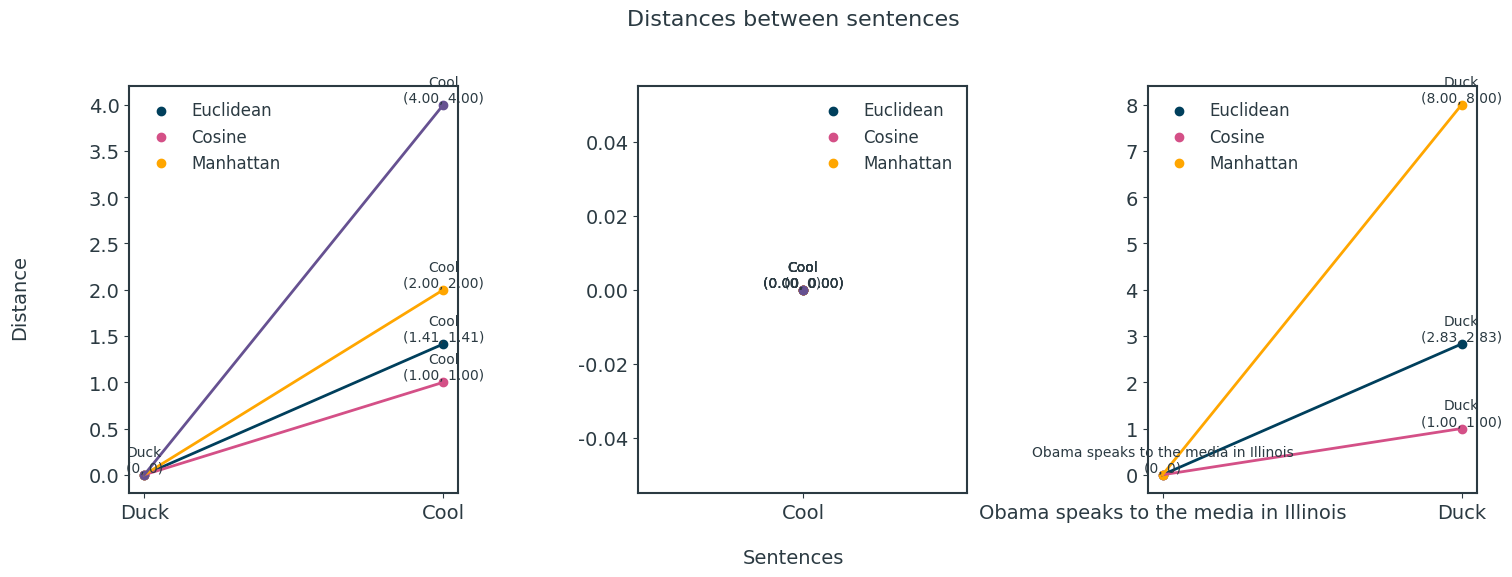

In [116]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot each pair on the same set of axes
plot_distances(s3, s4, vectorizer, ax=axes[0])
plot_distances(s4, s4, vectorizer, ax=axes[1])
plot_distances(s1, s3, vectorizer, ax=axes[2])

# Set labels and title for the entire figure
fig.suptitle('Distances between sentences', fontsize=16)
fig.text(0.5, 0.05, 'Sentences', ha='center', va='bottom', fontsize=14)
fig.text(0.07, 0.5, 'Distance', ha='center', va='center', rotation='vertical', fontsize=14)

plt.legend()
plt.tight_layout(rect=[0.1, 0.1, 0.9, 0.95])
plt.show()

Insight on euclidean vs cosine similarity

In [117]:
Q = "Good refrigerators"
D1 = "Good morning"
D2 = "Don't put pizza in the refrigerators"
D3 = "Good refrigerators review: top 10 good refrigerators"

helper = {
    "Q": "Good refrigerators",
    "D1": "Good morning",
    "D2": "Don't put pizza in the refrigerators",
    "D3": "Good refrigerators review: top 10 good refrigerators"
}

corpus = [Q, D1, D2, D3]
corpus_names = ['Q', 'D1', 'D2', 'D3']

vectorizer = CountVectorizer()
vectorizer.fit(corpus)

matrix = vectorizer.fit_transform(corpus)

table = matrix.todense()
df = pd.DataFrame(table, 
                  columns=vectorizer.get_feature_names_out(), 
                  index=corpus_names)

df.head()

# Considering only terms that appear in the query
df.drop(columns=['in', 'put', 'pizza', 'review', 'top', '10', 'don', 'morning', 'the'], inplace=True)
df.head()

,good,refrigerators
Q,1,1
D1,1,0
D2,0,1
D3,2,2


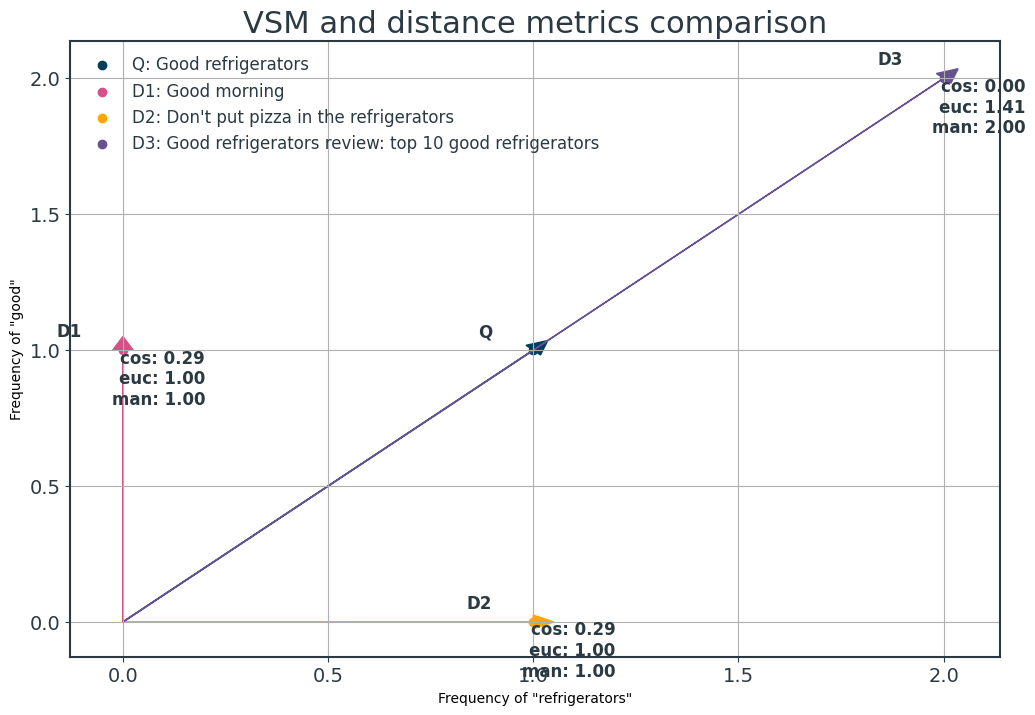

In [118]:
from scipy.spatial.distance import cosine, euclidean, cityblock
q_values = df.loc['Q'].values

plt.figure(figsize=(12, 8))
for index, doc in enumerate(corpus_names):
    color = colors[index]
    plt.scatter(df.loc[doc, 'refrigerators'], df.loc[doc, 'good'], label=f'{doc}: {helper[doc]}', color=color)
    plt.arrow(0, 0, df.loc[doc, 'refrigerators'], df.loc[doc, 'good'], 
              head_width=0.05, head_length=0.05, fc=color, ec=color)
    plt.text(df.loc[doc, 'refrigerators'] - 0.1, df.loc[doc, 'good'] + 0.05, doc, fontsize=12, ha='right', weight='bold')

    if doc == 'Q':
        continue
    values = df.loc[doc].values
    cos_sim = cosine(values, q_values)
    euc_dist = euclidean(values, q_values)
    man_dist = cityblock(values, q_values)
    plt.text(df.loc[doc, 'refrigerators'] + 0.2, df.loc[doc, 'good'] - 0.2, 
             f'cos: {cos_sim:.2f}\neuc: {euc_dist:.2f}\nman: {man_dist:.2f}', 
             fontsize=12, ha='right', weight='bold')

plt.title('VSM and distance metrics comparison')
plt.xlabel('Frequency of "refrigerators"', fontsize=10)
plt.ylabel('Frequency of "good"', fontsize=10)
plt.legend()
plt.grid(True)
plt.show()    

### Distribution distance

#### Algorithms

In [119]:
def kl_divergence(doc1, doc2):
    # Tokenize documents into words
    words1 = word_tokenize(doc1)
    words2 = word_tokenize(doc2)

    # Compute word frequencies for each document
    freq1 = Counter(words1)
    freq2 = Counter(words2)

    # Combine all unique words from both documents
    all_words = set(freq1.keys()) | set(freq2.keys())

    # Convert frequencies to probabilities
    total1 = len(words1)
    total2 = len(words2)
    prob1 = {word: (freq1[word] + 1) / (total1 + len(all_words)) for word in all_words}
    prob2 = {word: (freq2[word] + 1) / (total2 + len(all_words)) for word in all_words}

    # Compute KL divergence using scipy.stats.entropy
    kl_divergence = entropy(list(prob1.values()), qk=list(prob2.values()))

    return kl_divergence

def js_divergence(doc1, doc2):
    # Tokenize documents into words
    words1 = word_tokenize(doc1)
    words2 = word_tokenize(doc2)

    # Compute word frequencies for each document
    freq1 = Counter(words1)
    freq2 = Counter(words2)

    # Combine all unique words from both documents
    all_words = set(freq1.keys()) | set(freq2.keys())

    # Convert frequencies to probabilities
    total1 = len(words1)
    total2 = len(words2)
    prob1 = {word: (freq1[word] + 1) / (total1 + len(all_words)) for word in all_words}
    prob2 = {word: (freq2[word] + 1) / (total2 + len(all_words)) for word in all_words}

    # Compute average probabilities
    avg_prob = {word: (prob1[word] + prob2[word]) / 2 for word in all_words}

    # Compute JS divergence using KL divergence
    js_divergence = (entropy(list(prob1.values()), qk=list(avg_prob.values())) +
                     entropy(list(prob2.values()), qk=list(avg_prob.values()))) / 2

    return js_divergence

def calculate_wasserstein_distance(doc1, doc2):
    # Tokenize documents into words
    words1 = word_tokenize(doc1)
    words2 = word_tokenize(doc2)

    # Compute word frequencies for each document
    freq1 = Counter(words1)
    freq2 = Counter(words2)

    # Combine all unique words from both documents
    all_words = set(freq1.keys()) | set(freq2.keys())

    # Create distributions for the words in each document
    dist1 = [freq1[word] / len(words1) for word in all_words]
    dist2 = [freq2[word] / len(words2) for word in all_words]

    # Compute Wasserstein distance
    wasserstein_dist = wasserstein_distance(dist1, dist2)

    return wasserstein_dist

def get_distribution(document):
    # Split the document into words, convert to lower case, and count frequencies
    words = re.findall(r'\b\w+\b', document.lower())
    return Counter(words)

# Initialize a Porter stemmer
stemmer = PorterStemmer()

# Define a function to preprocess a document
def preprocess(document):
    # Tokenize the document
    words = word_tokenize(document)

    # Remove stopwords and stem the words
    words = [word for word in words if word not in stopwords.words('english')]

    # Join the words back into a string
    document = ' '.join(words)

    # Return the preprocessed document
    return document

In [120]:
document1 = """
The cat sat on the mat. The cat played with a ball of yarn. It loves the ball and the yarn.
The cat is a happy cat. A really happy cat.
"""
document2 = "Advanced algorithms are key for successful machine learning."

# Preprocess the documents
document1 = preprocess(document1)
document2 = preprocess(document2)

kl_divergence_result = kl_divergence(document1, document2)
js_divergence_result = js_divergence(document1, document2)
wasserstein_distance_result = calculate_wasserstein_distance(document1, document2)

print(f"KL divergence between documents: {kl_divergence_result:.3f}")
print(f"JS divergence between documents: {js_divergence_result:.3f}")
print(f"Wasserstein distance between documents: {wasserstein_distance_result:.3f}") 

KL divergence between documents: 0.303
JS divergence between documents: 0.077
Wasserstein distance between documents: 0.035


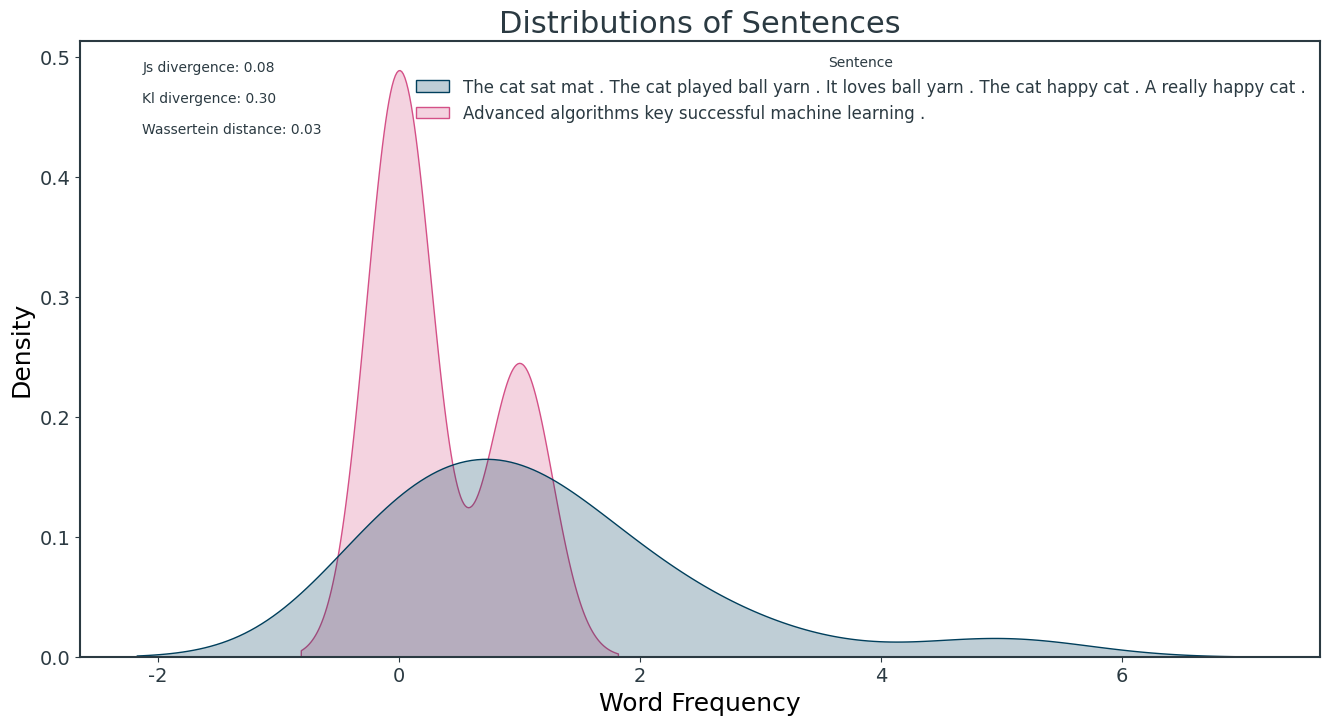

In [121]:
distribution1 = get_distribution(document1)
distribution2 = get_distribution(document2)

# Get all unique words from both distributions
all_words = list(set(distribution1.keys()) | set(distribution2.keys()))

# Create arrays for word frequencies in both distributions
freq1 = np.array([distribution1.get(word, 0) for word in all_words])
freq2 = np.array([distribution2.get(word, 0) for word in all_words])

# Create a DataFrame for Seaborn
df = pd.DataFrame({
    'Words': all_words,
    document1: freq1,
    document2: freq2
})

# Melt the DataFrame to have a format suitable for Seaborn
df_melted = df.melt(id_vars='Words', var_name='Sentence', value_name='Frequency')
# Plot KDE plots for each distribution
plt.figure(figsize=(16, 8))
sns.kdeplot(data=df_melted, x='Frequency', hue='Sentence', fill=True)

kl_divergence_result = kl_divergence(document1, document2)
js_divergence_result = js_divergence(document1, document2)
wasserstein_distance_result = calculate_wasserstein_distance(document1, document2)

plt.annotate(f'Js divergence: {js_divergence_result:.2f}', (0.05, 0.95), xycoords='axes fraction')
plt.annotate(f'Kl divergence: {kl_divergence_result:.2f}', (0.05, 0.90), xycoords='axes fraction')
plt.annotate(f'Wassertein distance: {wasserstein_distance_result:.2f}', (0.05, 0.85), xycoords='axes fraction')

# Set labels and title
plt.xlabel('Word Frequency')
plt.title('Distributions of Sentences')
plt.show()

### Semantic distance

In [122]:
from gensim.models import KeyedVectors

word2vec_path = '/Users/micheledinelli/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz'
w2v_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [123]:
document1 = "the cat sat on the mat."
document2 = "the dog sat on the mat."

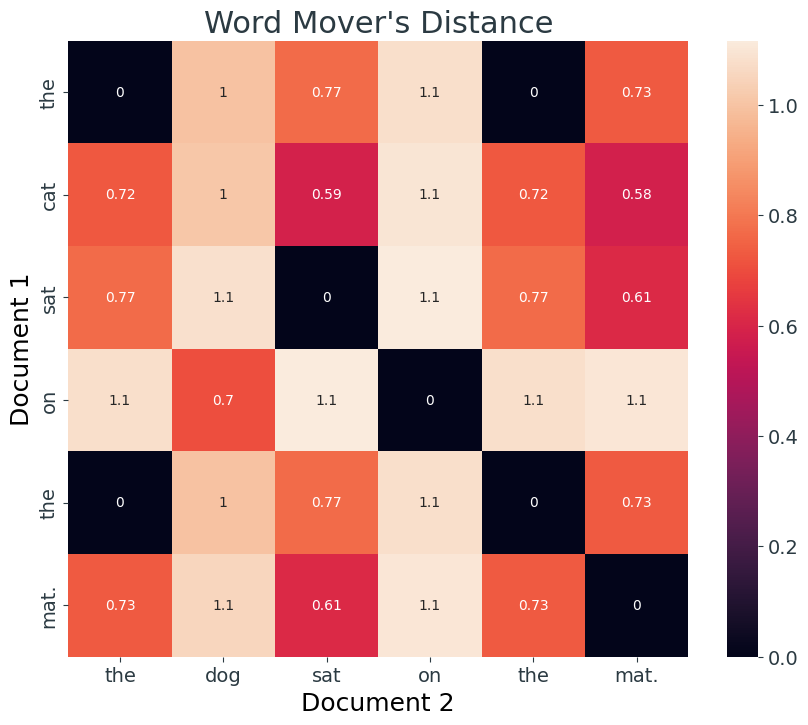

In [124]:
# Create a matrix of word distances
word_distances = np.zeros((len(document1.split()), len(document2.split())))
for i, word1 in enumerate(document1.split()):
    for j, word2 in enumerate(document2.split()):
        word_distances[i, j] = w2v_model.wmdistance(word1, word2)

# Create a heatmap of word distances
plt.figure(figsize=(10, 8))
sns.heatmap(word_distances, annot=True, cmap="rocket", xticklabels=document2.split(), yticklabels=document1.split())
plt.title('Word Mover\'s Distance')
plt.xlabel('Document 2')
plt.ylabel('Document 1')
plt.show()


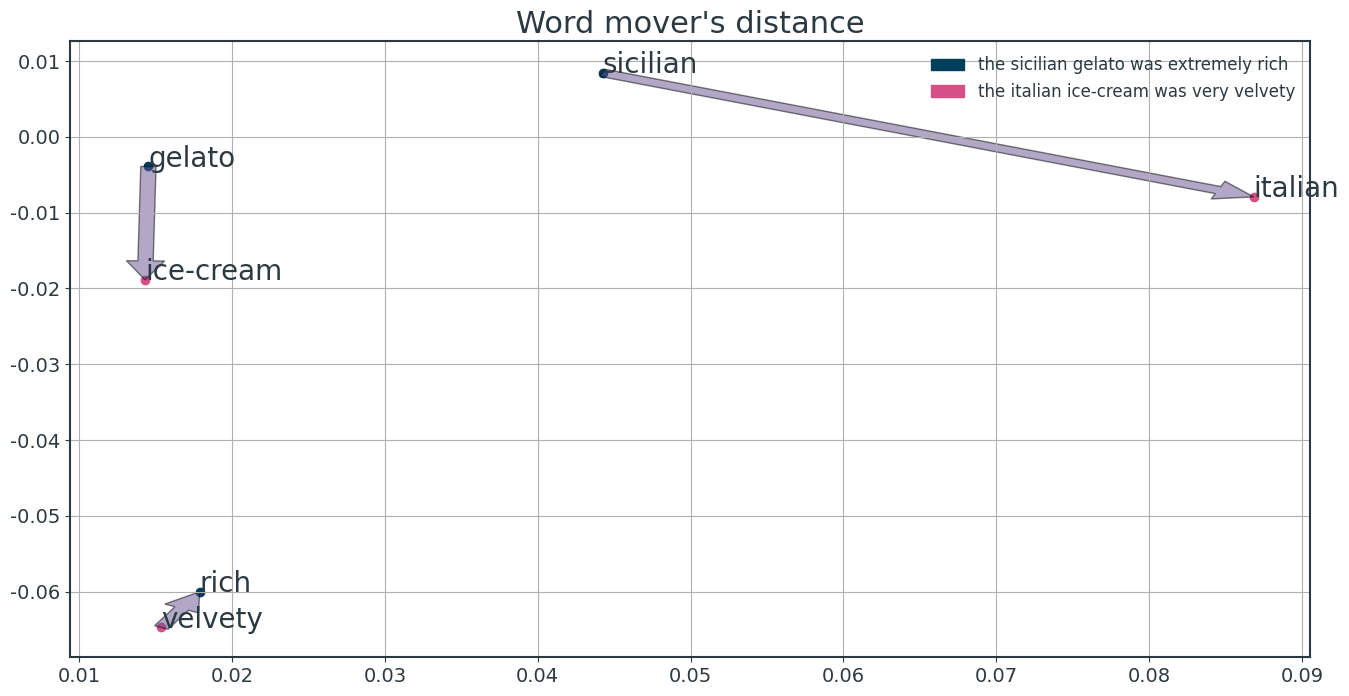

In [125]:
import matplotlib.patches as mpatches

train_sentences = [
    "the italian gelato served in sicily was extremely rich",
    "sicily is an italian region",
    "gelato is a popular dessert in Italy",
    "gelato is a type of soft ice-cream",
    "gelato is ice-cream",
    "sicily is a great place to visit in italian summer",
    "italian most famous sea is in sicily",
    "ice-cream is a soft gelato"
]

# Tokenize sentences
og_sentences = [
    "the sicilian gelato was extremely rich",
    "the italian ice-cream was very velvety",
]

sentences = [nltk.word_tokenize(sentence) for sentence in og_sentences] + [nltk.word_tokenize(sentence) for sentence in train_sentences]

stop_words = set(stopwords.words('english'))
og_sentences_tok = [[word for word in nltk.word_tokenize(sentence) if word not in stop_words] for sentence in og_sentences]

# Train Word2Vec model
model = Word2Vec(sentences, vector_size=20, window=5, min_count=1, workers=4)

# Get all word vectors
word_vectors = model.wv.vectors

# Fit a PCA model to the word vectors
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

# Create a scatter plot of the word vectors
plt.figure(figsize=(16, 8))

maps = {
    "sicilian": "italian",
    "gelato": "ice-cream",
    "velvety": "rich"
}

# Add labels to the points
for i, sentence in enumerate(og_sentences_tok):
    for word in sentence:
        if word in model.wv:
            if word == "extremely":
                continue
            word_vector_2d = pca.transform(model.wv[word].reshape(1, -1))
            plt.scatter(word_vector_2d[:, 0], word_vector_2d[:, 1], color=colors[i % len(colors)])
            plt.annotate(word, xy=(word_vector_2d[0, 0], word_vector_2d[0, 1]), fontsize=20)

for word1, word2 in maps.items():
    if word1 in model.wv and word2 in model.wv:
        word1_vector_2d = pca.transform(model.wv[word1].reshape(1, -1))
        word2_vector_2d = pca.transform(model.wv[word2].reshape(1, -1))
        plt.arrow(word1_vector_2d[0, 0], word1_vector_2d[0, 1], word2_vector_2d[0, 0] - word1_vector_2d[0, 0], 
                  word2_vector_2d[0, 1] - word1_vector_2d[0, 1], fc=color, ec="black", head_width=0.0025, head_length=0.0025, alpha=0.5,
                  length_includes_head=True)

# Create a list of patches for the legend
legend_patches = [mpatches.Patch(color=colors[i % len(colors)], label=sentence) for i, sentence in enumerate(og_sentences)]

plt.grid(True)
plt.title("Word mover's distance")
plt.legend(handles=legend_patches, loc='upper right', fontsize='large')
plt.show()

In [126]:
def visualize_lcs_matrix(X, Y, lcs_matrix, longest_common_subsequence):
    fig, ax = plt.subplots()
    ax.set_title('Longest Common Subsequence Matrix')
    cax = ax.matshow(lcs_matrix, cmap='rocket')

    for i in range(len(X) + 1):
        for j in range(len(Y) + 1):
            ax.text(j, i, str(lcs_matrix[i, j]), ha='center', va='center', color='gray')

    ax.set_xticks(np.arange(len(Y) + 1))
    ax.set_yticks(np.arange(len(X) + 1))
    ax.set_xticklabels([''] + list(Y), fontsize=20)
    ax.set_yticklabels([''] + list(X), fontsize=20)
    plt.colorbar(cax)
    fig.text(0.5, 0.05, "Longest Common Subsequence: " + longest_common_subsequence, ha='center', va='bottom', fontsize=14)
    plt.show()

Length of Longest Common Subsequence: 3
Longest Common Subsequence: ool


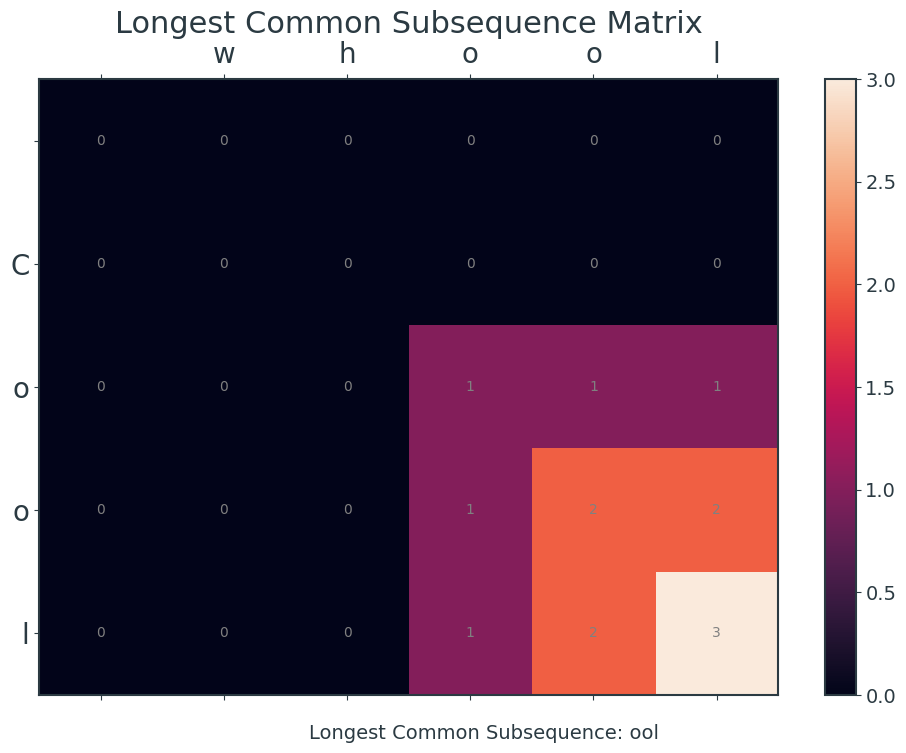

In [127]:
def longest_common_subsequence(X, Y):
    m = len(X)
    n = len(Y)

    # Create a matrix to store lengths of LCS
    lcs_matrix = np.zeros((m+1, n+1), dtype=int)

    # Build the matrix
    for i in range(1, m+1):
        for j in range(1, n+1):
            if X[i-1] == Y[j-1]:
                lcs_matrix[i][j] = lcs_matrix[i-1][j-1] + 1
            else:
                lcs_matrix[i][j] = max(lcs_matrix[i-1][j], lcs_matrix[i][j-1])

    # Find the length of LCS
    length_lcs = lcs_matrix[m][n]

    # Find the actual LCS
    lcs = []
    i, j = m, n
    while i > 0 and j > 0:
        if X[i-1] == Y[j-1]:
            lcs.insert(0, X[i-1])
            i -= 1
            j -= 1
        elif lcs_matrix[i-1][j] > lcs_matrix[i][j-1]:
            i -= 1
        else:
            j -= 1

    return length_lcs, ''.join(lcs), lcs_matrix

length_lcs, lcs_sequence, lcs_matrix = longest_common_subsequence(s4, "whool")
print(f"Length of Longest Common Subsequence: {length_lcs}")
print(f"Longest Common Subsequence: {lcs_sequence}")

visualize_lcs_matrix(s4, "whool", lcs_matrix, lcs_sequence)


In [128]:
# import spacy
# import plotly.express as px

# # Load the English language model
# nlp = spacy.load("en_core_web_md")

# # Define the words for which you want vectors
# words = ["man", "woman", "king", "queen"]

# # Get the vectors for each word
# vectors = [nlp(word).vector for word in words]

# # Perform the vector operation (King - Man + Woman)
# result_vector = nlp("king").vector - nlp("man").vector + nlp("woman").vector

# # Combine the word vectors and result vector
# all_vectors = vectors + [result_vector]

# # Use PCA to reduce the dimensionality to 3 for visualization
# pca = PCA(n_components=3)
# vectors_3d = pca.fit_transform(all_vectors)

# # Create a DataFrame for visualization
# import pandas as pd
# df = pd.DataFrame(vectors_3d, columns=['PC1', 'PC2', 'PC3'])
# df['Word'] = words + ['King - Man + Woman']

# # Plot the 3D vectors
# fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', text='Word')

# # Update the layout for better visibility
# fig.update_layout(title="Word Vectors Visualization with Result Vector",
#                   scene=dict(xaxis_title='Principal Component 1',
#                              yaxis_title='Principal Component 2',
#                              zaxis_title='Principal Component 3'))

# # Show the plot
# fig.show()
